In [404]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from collections import OrderedDict
%matplotlib inline

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits

%matplotlib inline

# 2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$ : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$: 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$: 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\ b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配  $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\ \frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。


MNISTはデータサイズが大きいので、いったん[Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)のコピーである、[sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)を使って、正しく動いているか検証してみましょう。

### 【テストデータ作成】

(1797, 8, 8)
0


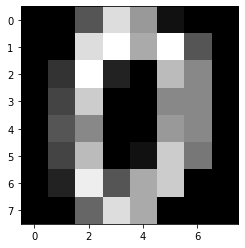

1


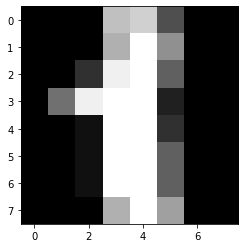

(1797, 1, 8, 8)


In [101]:
X,y = load_digits(n_class = 10, return_X_y = True, as_frame = False)
X = X.reshape((-1,8,8))
print(X.shape)
for i in range(2):
    print(y[i])
    plt.imshow(X[i],"gray")
    plt.show()

X = X[:, np.newaxis, :, :]
print(X.shape)

標準化/正規化ももちろん必須なので、してあげましょう。

モノクロ画像なので、チャンネル側がありませんが、reshapeして、チャンネル方向に拡張してください。

In [102]:
# 正規化
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(np.max(X)) # 1.0
print(np.min(X)) # 0.0

1.0
0.0


In [103]:
# one-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64

(1797,)
(1797, 10)
float64


In [104]:
#split
X_train,X_test,y_train,y_test = train_test_split(X,y_one_hot)

In [105]:
X_train.shape

(1347, 1, 8, 8)

In [106]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### 【解答】conv関数

In [396]:
class Conv2d:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def _calc_out_shape(self, Nin, fh, fw):
        #NCHWの場合
        h, w = Nin.shape[2],Nin.shape[3]

        out_h = int((h + 2*self.pad - fh) / self.stride +1)
        out_w = int((w + 2*self.pad - fw) / self.stride + 1)

        return out_h, out_w

    def forward(self, X):
        FN, C, FH, FW = self.W.shape
        N, C, H, W =X.shape
        out_h, out_w = self._calc_out_shape(X, FH, FW)
        
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        print("after np.dot shape : {}".format(out.shape))
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        print("out shape : {}".format(out.shape))
        
        self.X = X
        self.col = col
        self.col_W = col_W

        return out    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        
        self.dW = self.dW.transpose(1,0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        
        dX = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        return dX
        
        

In [397]:
W = np.random.randn(32,1,3,3)
#print(W.shape)
#col_W = W.reshape(32, -1).T # フィルターの展開
#col_W.shape
b = np.zeros(32,)

In [398]:
test = Conv2d(W,b)
out = test.forward(X_train)
out.shape

col_shape before transpose :(1347, 1, 3, 3, 6, 6)
after np.dot shape : (48492, 32)
out shape : (1347, 32, 6, 6)


(1347, 32, 6, 6)

In [399]:
back = test.backward(out)
back.shape

(1347, 1, 8, 8)

shapeの遷移は、

* 入力時 : (1347,1,8,8)
* forward propagation出力時 : (1347,32,6,6)
* back propagation出力時 : (1347,1,8,8)

となったので、数値は見ていないがshapeの動きは正しいと思われる。


# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} = \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\ N_{w,out} = \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、 $w$ が幅方向である

### 【解答】

In [181]:
def calc_out_shape(Nin, F=(3,3), P=(0, 0), S=(1,1)):
    #NCHWの場合
    h, w = Nin.shape[2],Nin.shape[3]
    #print(h,w)
    fh, fw = F[0], F[1]
    ph, pw = P[0], P[1]
    sh, sw = S[0], S[1]
    
    h_out = int((h + 2*ph - fh) / sh +1)
    w_out = int((w + 2*pw - fw) / sw + 1)
    
    return h_out, w_out

In [182]:
calc_out_shape(X)

(6, 6)

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）

$S_{h}, S_{w}$  : 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$: 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
$(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

### 【解答】

In [389]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.X = None
        self.arg_max = None
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print("col:{}".format(col.shape))
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #print("im2col out & reshape:{}\n".format(col))
        
        arg_max = np.argmax(col, axis=1) # colの各配列のなかで一番大きい値のインデックスを持っている配列
        #print(arg_max[0])
        #最大値(2)
        out = np.max(col, axis=1)
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        #print("out:\n{}\n".format(out))

        self.X = X
        self.arg_max = arg_max

        return out

    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # doutを順番入れ替え　(0,1,2,3) (0,3,1,2) (0,2,3,1) 元に戻ってる 
        print("transpose:{}".format(dout.shape))
        #print("dout transpose:{}".format(dout))
        
        pool_size = self.pool_h * self.pool_w # pool_sizeを計算
        print("pool_size:{}".format(pool_size))
    
        dmax = np.zeros((dout.size, pool_size)) # dmax = (doutのサイズ,プールサイズ)
        #print("dmax_size:{}".format(dmax.shape))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # dmaxの0~arg_max.size行の最大値インデックス列に、doutをflattenしたものを追加していく
        print("dmax_size(flatten):{}".format(dmax.shape))
        dmax = dmax.reshape(dout.shape + (pool_size,)) # 
        print("dmax_size(reshape):{}".format(dmax.shape))
        #print("dmax:{}".format(dmax))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) # dcolはdmaxをreshapeして作る
        print("dcol_size:{}".format(dcol.shape))
        #print("dcol:{}".format(dcol))
        dX = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad) # dcolをcol2imに通して出力
        print("dX_size:{}".format(dX.shape))
        print(dX)
        
        return dX

In [371]:
test3 = np.random.randint(0,9,(1,1,4,4))
test3

array([[[[6, 0, 1, 2],
         [1, 7, 2, 1],
         [5, 6, 4, 2],
         [6, 5, 2, 6]]]])

In [393]:
tmp = Pooling(2,2,stride=2, pad=0)

In [394]:
pool_test = tmp.forward(test3)
pool_test.shape

col_shape before transpose :(1, 1, 2, 2, 2, 2)


(1, 1, 2, 2)

In [395]:
pooling_back = tmp.backward(pool_test)
pooling_back.shape

transpose:(1, 2, 2, 1)
pool_size:4
dmax_size(flatten):(4, 4)
dmax_size(reshape):(1, 2, 2, 1, 4)
dcol_size:(4, 4)
dX_size:(1, 1, 4, 4)
[[[[0. 0. 0. 2.]
   [0. 7. 0. 0.]
   [0. 6. 0. 0.]
   [0. 0. 0. 6.]]]]


(1, 1, 4, 4)

# 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。



### 【解答】

In [206]:
class Average_Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print(col.shape)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        print(col[0])
        #最大値(2)
        out = np.mean(col, axis=1)
        print(out[0])
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
        

In [207]:
temp = Average_Pooling(3,3)
mean_pool = temp.forward(out)
mean_pool[0][0]

col_shape before transpose :(1347, 32, 3, 3, 4, 4)
[0.66466979 0.79953291 0.596617   0.45401189 0.95124222 0.98708122
 0.31068093 1.20061788 0.87264838]
0.7596780237365981


array([[0.75967802, 1.05466894, 1.19378094, 0.94502212],
       [0.8407299 , 0.97617051, 1.16713542, 0.96694031],
       [0.73403034, 0.86693414, 1.16479646, 1.06228871],
       [0.58931271, 0.95872787, 1.34424983, 1.30689418]])

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。



### 【解答】平滑化関数

In [251]:
class Flatten:
    def __init__(self):
        self.shape = None
    
    def forward(self, Z):
        self.shape = Z.shape
        return Z.reshape(self.shape[0], np.prod(self.shape[1:]))
    
    def backward(self, dX):
        return dX.reshape(self.shape)

In [255]:
print("平滑化前:{}".format(out.shape))
flat = Flatten()
dx = flat.forward(out)
print("平滑化関数出力:{}".format(dx.shape))
z = flat.backward(dx)
print("元に戻す:{}".format(z.shape))

平滑化前:(1347, 32, 6, 6)
平滑化関数出力:(1347, 1152)
元に戻す:(1347, 32, 6, 6)


ちゃんとshape変更できている。

### 時間計測

ちょっと気になったので、np.ravelとnp.prodのどっちが早いのか測ってみたところ、prodの方が早かった。

なので平滑化はprodで実装する。

In [257]:
%%timeit -r 1 -n 1
# 簡略化のため1回分しか計測していないが、10000回やって平均とってもprodのが早かった。
np.prod(out.shape)

51.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [258]:
%%timeit  -r 1 -n 1
np.ravel(out)

3.59 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

### MNISTデータの準備

In [510]:
from keras.datasets import mnist

In [511]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 1, 28, 28)
(10000, 1, 28, 28)
uint8


In [512]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y_train[:, np.newaxis])
print(y_train.shape) # (100000,)
print(y_one_hot.shape) # (100000, 2)
print(y_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [513]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_one_hot)


In [514]:
X_train.shape

(45000, 1, 28, 28)

In [515]:
y_train.shape

(45000, 10)

In [554]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
        
    Returns
    -------
    col : 2次元配列
    """
    #print(input_data)
    #print("im2col input shape :{}".format(input_data.shape))
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
        
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        
    #print("before transpose shape : {}".format(col.shape))
    #print(col)
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    #print("after im2col shape : {}".format(col.shape))
    return col

In [456]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [457]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [518]:
# ReLU関数クラス

class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dX = dout
        
        return dX            


# シグモイド関数クラス

class Simoid:
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = 1 / (1+np.exp(-X))
        return self.out
    
    def backward(self, dout):
        dX = doutt * (1.0 - self.out) * self.out
        return dX
    
    
# 全結合層クラス

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.X = None
        self.original_X_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None
        
    def forward(self, X):
        # テンソル対応
        self.original_X_shape = X.shape
        X = X.reshape(X.shape[0], -1)
        self.X = X
        
        out = np.dot(self.X, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db =np.sum(dout, axis=0)
        
        dX = dX.reshape(*self.original_X_shape) # 入力データの形状に戻す(テンソル対応)
        
        return dX
    
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self, X, t):
        """
        X : 入力データ
        t : 教師データ
        """
        self.t = t
        self.y = softmax(X)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dX = (self.y - self.t) / batch_size
        else:
            dX = self.y.copy()
            dX[np.arrange(batch_size), self.t] -= 1
            dX = dX / batch_size
        
        return dX
    

    
# 畳み込み層クラス

class Conv2d:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def _calc_out_shape(self, Nin, fh, fw):
        #NCHWの場合
        h, w = Nin.shape[2],Nin.shape[3]

        out_h = int((h + 2*self.pad - fh) / self.stride +1)
        out_w = int((w + 2*self.pad - fw) / self.stride + 1)

        return out_h, out_w

    def forward(self, X):
        FN, C, FH, FW = self.W.shape
        N, C, H, W =X.shape
        out_h, out_w = self._calc_out_shape(X, FH, FW)
        
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        
        #print("after np.dot shape : {}".format(out.shape))
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        #print("out shape : {}".format(out.shape))
        
        self.X = X
        self.col = col
        self.col_W = col_W

        return out    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        
        self.dW = self.dW.transpose(1,0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        
        dX = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        return dX

    
# プーリングクラス

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.X = None
        self.arg_max = None
        
    def forward(self, X):
        N,C,H,W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        #print("col:{}".format(col.shape))
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #print("im2col out & reshape:{}\n".format(col))
        
        arg_max = np.argmax(col, axis=1) # colの各配列のなかで一番大きい値のインデックスを持っている配列
        #print(arg_max[0])
        #最大値(2)
        out = np.max(col, axis=1)
        
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        #print("out:\n{}\n".format(out))

        self.X = X
        self.arg_max = arg_max

        return out

    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # doutを順番入れ替え　(0,1,2,3) (0,3,1,2) (0,2,3,1) 元に戻ってる 
        #print("transpose:{}".format(dout.shape))
        #print("dout transpose:{}".format(dout))
        
        pool_size = self.pool_h * self.pool_w # pool_sizeを計算
        #print("pool_size:{}".format(pool_size))
    
        dmax = np.zeros((dout.size, pool_size)) # dmax = (doutのサイズ,プールサイズ)
        #print("dmax_size:{}".format(dmax.shape))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # dmaxの0~arg_max.size行の最大値インデックス列に、doutをflattenしたものを追加していく
        #print("dmax_size(flatten):{}".format(dmax.shape))
        dmax = dmax.reshape(dout.shape + (pool_size,)) # 
        #print("dmax_size(reshape):{}".format(dmax.shape))
        #print("dmax:{}".format(dmax))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) # dcolはdmaxをreshapeして作る
        #print("dcol_size:{}".format(dcol.shape))
        #print("dcol:{}".format(dcol))
        dX = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad) # dcolをcol2imに通して出力
        #print("dX_size:{}".format(dX.shape))
        #print(dX)
        
        return dX



In [519]:
conv_param={'filter_num':32, 'filter_size':3, 'pad':0, 'stride':1}

class SimpleConvnet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), conv_param=conv_param, hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの作成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Conv2d(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers["ReLU1"] = ReLU()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["ReLU2"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        
        self.last_layer = SoftmaxWithLoss()
        
        print("レイヤの初期化完了")
    
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        
        print("predict完了")
        
        return X
    
    def loss(self, X, t):
        """
        損失関数を求める
        引数のXは入力データ、tは正解ラベル
        例：loss(X_train, y_train)
        """
        y = self.predict(X)
        print("loss完了")
        
        return self.last_layer.forward(y, t)
    
    def accuracy(self, X, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
            
        acc = 0.0
        
        for i in range(int(X.shape[0] / batch_size)):
            tX = X[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tX)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == y)
        
        print("accuracy完了")
        
            
        return acc / X.shape[0]

    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]            
            

In [497]:
# optimizerクラスまとめ

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [529]:
class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=5, mini_batch_size=100,
                 optimizer='AdaGrad', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=False):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

レイヤの初期化完了
train loss:1.762868366960376
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:1.5933201131125774
train loss:1.2186131339890114
train loss:1.4055079009052418
train loss:1.2899185945670038
train loss:0.9419109445011642
train loss:0.8701744106249886
train loss:0.6756982727728529
train loss:0.6616575196307791
train loss:0.7304833546122513
train loss:0.6064031270388559
train loss:0.5101162456422008
train loss:0.3929089280020618
train loss:0.5160390102328095
train loss:0.4660951978866461
train loss:0.5376439072735715
train loss:0.6770273440683148
train loss:0.6424332186548385
train loss:0.37102353665017956
train loss:0.4564794306928324
train loss:0.4426406704747609
train loss:0.5347797034250217
train loss:0.36968822700734705
train loss:0.31795562734416516
train loss:0.29857844787189425
train loss:0.4215425858031072
train loss:0.4147275672088738
train loss:0.40425648376160744
train loss:0.2290886531389255
train loss:0.28346601621196055
train loss:0.25624956486647027
train los

train loss:0.1303592169573185
train loss:0.08434251383580635
train loss:0.15014088936837103
train loss:0.06957763895670137
train loss:0.186395382690232
train loss:0.08073110842232813
train loss:0.16446878535982778
train loss:0.1017959465888735
train loss:0.06590517422702431
train loss:0.11053755258021593
train loss:0.11964996969869611
train loss:0.09765737993661446
train loss:0.13533055369032415
train loss:0.11904923442446558
train loss:0.08106426918523862
train loss:0.1278549525163004
train loss:0.08552533602254696
train loss:0.16791938707173693
train loss:0.1714043221349077
train loss:0.10153332194529512
train loss:0.09889110552441346
train loss:0.22543608334369714
train loss:0.10224310428898276
train loss:0.08932070975043802
train loss:0.05861252277347126
train loss:0.07931461639548934
train loss:0.044538021421600994
train loss:0.15409942956684297
train loss:0.10138708387022335
train loss:0.14902156718794987
train loss:0.10775454231850354
train loss:0.11822556679562247
train loss:0.

train loss:0.08738123249443613
train loss:0.07313225908137765
train loss:0.13263024636346663
train loss:0.0561921949657589
train loss:0.04617353100649347
train loss:0.06372634694401975
train loss:0.04636868256874831
train loss:0.06239454065082992
train loss:0.06152111082929757
train loss:0.08043517456323858
train loss:0.11623716960911842
train loss:0.06313208884676312
train loss:0.050662098563806664
train loss:0.07805144540175117
train loss:0.07146741596666935
train loss:0.07645297585277996
train loss:0.12193550415014891
train loss:0.08360963105574619
train loss:0.038419887713927035
train loss:0.04486447514568168
train loss:0.07219495900559317
train loss:0.056524784600016885
train loss:0.05517809738028998
train loss:0.033024492326882475
train loss:0.12103829530704009
train loss:0.12518671530389658
train loss:0.09913526979961565
train loss:0.08465410382672013
train loss:0.119690247949805
train loss:0.09966685672657953
train loss:0.07224443956412531
train loss:0.08088518321381458
train l

train loss:0.04509600207849826
train loss:0.07451404963777425
train loss:0.04555770342461969
train loss:0.045068740300977156
train loss:0.038176211656900085
train loss:0.029176721876802193
train loss:0.07740427374080344
train loss:0.017810776904421555
train loss:0.06865662595271582
train loss:0.01753711340772859
train loss:0.16850657078655423
train loss:0.1117408575620633
train loss:0.09021414676972019
train loss:0.10515834113326157
train loss:0.11831790484034829
train loss:0.053901951670369284
train loss:0.0487998917828509
train loss:0.04424561111960002
train loss:0.030149151262361163
train loss:0.03567060345651281
train loss:0.11384124025406399
train loss:0.07051172809049637
train loss:0.06623976444323591
train loss:0.07395675809029353
train loss:0.09067817244103273
train loss:0.05321937039580036
train loss:0.04199599088607784
train loss:0.04080927416270172
train loss:0.05173721119262544
train loss:0.06733260101075535
train loss:0.052031711741352175
train loss:0.040651076559142824
tr

train loss:0.06169451513816901
train loss:0.108074784570223
train loss:0.03387458639401363
train loss:0.047756310099446295
train loss:0.033896873394920514
train loss:0.07249992285037055
train loss:0.08171180319689832
train loss:0.03407426859042691
train loss:0.06952592174384413
train loss:0.10651114849217277
train loss:0.10906617604226783
train loss:0.04325613818660318
train loss:0.026859014276278063
train loss:0.01947973394156135
train loss:0.02090045172017553
train loss:0.04244765799371202
train loss:0.03044536086972748
train loss:0.0704604790959614
train loss:0.0361092897744314
train loss:0.09676323912230757
train loss:0.07474025816548778
train loss:0.03759874007931656
train loss:0.05100250199678721
train loss:0.04661272475371168
train loss:0.04561234145269875
train loss:0.06019991363402711
train loss:0.08763203445209836
train loss:0.046118711291191807
train loss:0.03798091303582465
train loss:0.037915870962138665
train loss:0.062067254274972915
train loss:0.034982427623051156
train

train loss:0.03962636225305846
train loss:0.018294617631787097
train loss:0.04120702329386765
train loss:0.06164438508781012
train loss:0.05023891754207232
train loss:0.15950085785694024
train loss:0.11130599690298572
train loss:0.04475941243357315
train loss:0.025257010328474324
train loss:0.051044678314410064
train loss:0.05034666864805048
train loss:0.023719231372909676
train loss:0.12100292854154901
train loss:0.03645021377621024
train loss:0.0830198500947488
train loss:0.13252887322906176
train loss:0.06114536888981009
train loss:0.09777955623996774
train loss:0.029558427096585533
train loss:0.03928049884725275
train loss:0.04946563321520357
train loss:0.04743836824469007
train loss:0.04014751821246068
train loss:0.030445574440351543
train loss:0.08348619219657497
train loss:0.08658403530473573
train loss:0.07832467140717164
train loss:0.07575820249531072
train loss:0.02543858852387939
train loss:0.04119731544908227
train loss:0.06423674035283265
=== epoch:4, train acc:1.0, test a

train loss:0.014764747990445777
train loss:0.028568697134899575
train loss:0.02170671201997869
train loss:0.06134523391687175
train loss:0.05711518611181894
train loss:0.011619832852406553
train loss:0.03469408331265683
train loss:0.02501201430043808
train loss:0.03941786303643712
train loss:0.02164834136293865
train loss:0.06767567651041487
train loss:0.022121283577236972
train loss:0.09307218068233941
train loss:0.04404240802997863
train loss:0.2386776378135308
train loss:0.028910938768369875
train loss:0.04161650853097137
train loss:0.022520307674414704
train loss:0.06371519663309666
train loss:0.07843968125621101
train loss:0.10716498269499335
train loss:0.03571330122988142
train loss:0.05799176329659136
train loss:0.018353138076783748
train loss:0.03662363534904433
train loss:0.03665838371210822
train loss:0.11506699677998097
train loss:0.1354061664607782
train loss:0.035210299350986046
train loss:0.02245060573717903
train loss:0.07516437926881257
train loss:0.048024785982103774
t

train loss:0.018678099161688708
train loss:0.030519350999772366
train loss:0.12705726868992007
train loss:0.02589941879324241
train loss:0.016966056337114864
train loss:0.02377099891255782
train loss:0.024740759134256482
train loss:0.06793176576826318
train loss:0.05371761133142262
train loss:0.027374436980333074
train loss:0.03953311643856906
train loss:0.04417463359023069
train loss:0.03079796710144005
train loss:0.02927330984253447
train loss:0.04568145722338713
train loss:0.05377272368387155
train loss:0.02507929820722723
train loss:0.07804976245832608
train loss:0.03229616853318441
train loss:0.07024286158907977
train loss:0.049088517175687005
train loss:0.05858023658216051
train loss:0.02709537330064491
train loss:0.026640805448378803
train loss:0.03475614882125342
train loss:0.01739466654214016
train loss:0.06627119665666326
train loss:0.015483274556566267
train loss:0.04013631592176934
train loss:0.15781067815581504
train loss:0.02498687971062836
train loss:0.03942857480877111


train loss:0.02670356954843974
train loss:0.0592458556077994
train loss:0.018915910448993475
train loss:0.04067610514997536
train loss:0.014615977835023351
train loss:0.025323116999482576
train loss:0.055384898555727397
train loss:0.055483530587659036
train loss:0.027446995055953147
train loss:0.1226973422445667
train loss:0.04968869904002928
train loss:0.019340489322983177
train loss:0.045292080054313066
train loss:0.014306237330494216
train loss:0.016290657926215705
train loss:0.03976350063349962
train loss:0.0218374683205592
train loss:0.035500524311654125
train loss:0.03982731211821751
train loss:0.01745242268652104
train loss:0.015993395547284118
train loss:0.04637469659729944
train loss:0.01808635221960865
train loss:0.030612724029830413
train loss:0.033288446567286904
train loss:0.03375649539200062
train loss:0.08007312817890094
train loss:0.03326917089105507
train loss:0.016277000414725903
train loss:0.08677270925225354
train loss:0.011186445398815983
train loss:0.0393972179536

train loss:0.030101752330300387
train loss:0.03302723753346654
train loss:0.02455512112893162
train loss:0.05552637725693032
train loss:0.06255443988511718
train loss:0.01570217535563997
train loss:0.05278149362890205
train loss:0.020772970767485063
train loss:0.04842327063008619
train loss:0.029346036326045283
train loss:0.02406415352744652
train loss:0.020453655622304848
train loss:0.013396141535040318
train loss:0.029887754372576562
train loss:0.012714752856890799
train loss:0.009588490879754882
train loss:0.02865421801989062
train loss:0.050173630146712014
train loss:0.022324454723563255
train loss:0.11302598863680037
train loss:0.02986905238597741
train loss:0.04366314999762508
train loss:0.029636210657097362
train loss:0.04538031285449266
train loss:0.054010330377533215
train loss:0.019701609379697105
train loss:0.030704471005367884
train loss:0.02082704674937141
train loss:0.022685456406331968
train loss:0.03456169887155187
train loss:0.0385760456280566
train loss:0.041072570393

train loss:0.021542524716206053
train loss:0.038383337359485334
train loss:0.02885732879215083
train loss:0.05512102829778926
train loss:0.018515223386736317
train loss:0.010844117456505537
train loss:0.015402974300937749
train loss:0.06434703530230741
train loss:0.013611260599508759
train loss:0.008295080293223176
train loss:0.019064050442861514
train loss:0.021083522908981335
train loss:0.05144953339271674
train loss:0.0822052642518955
train loss:0.043686938189659796
train loss:0.05809008794289284
train loss:0.03444323822937343
train loss:0.035493170143320964
train loss:0.03842725635505678
train loss:0.059704647858678364
train loss:0.03551111953030636
train loss:0.015498448202182531
train loss:0.08149723680811015
train loss:0.030045943350051552
train loss:0.012402017574988268
train loss:0.07839108824470215
train loss:0.09155789650414693
train loss:0.02881564409963796
train loss:0.030632720438208808
train loss:0.02269601415584426
train loss:0.0371490542237831
train loss:0.025339805595

train loss:0.05086582694457877
train loss:0.08427158278983575
train loss:0.05892645102690396
train loss:0.0157326414825087
train loss:0.02883638246128738
train loss:0.014984100299397894
train loss:0.03344879576944946
train loss:0.1040255295272991
train loss:0.02787015680404388
train loss:0.024503063487172225
train loss:0.009580794961573227
train loss:0.04758182293758592
train loss:0.0276710601521121
train loss:0.015208077103755763
train loss:0.023074866822541965
train loss:0.020662302536438658
train loss:0.08975128462354767
train loss:0.04278476762832191
train loss:0.028346096415677646
train loss:0.02737685139530774
train loss:0.06754931269907229
train loss:0.04345298673395864
train loss:0.05064701790676858
train loss:0.021688727255602367
train loss:0.08874993353768038
train loss:0.1283262521629489
train loss:0.0320930409756167
train loss:0.055769998239445326
train loss:0.019460036295261204
train loss:0.011041385073695249
train loss:0.06676822159885488
train loss:0.07323539533627345
tr

train loss:0.013621348513949819
train loss:0.05973333276702242
train loss:0.021398642111209818
train loss:0.088840180086137
train loss:0.06208554508838098
train loss:0.03390735591669941
=== epoch:8, train acc:1.0, test acc:1.0 ===
train loss:0.02773668169301466
train loss:0.028945842804525373
train loss:0.019276427684144542
train loss:0.033935428686832705
train loss:0.066515323123288
train loss:0.020013243987073544
train loss:0.04000242413402357
train loss:0.03242337149561808
train loss:0.12149771314312349
train loss:0.027679562238956342
train loss:0.01534927675963621
train loss:0.05734545879096457
train loss:0.016524511340887237
train loss:0.033466848006674994
train loss:0.08620751669780599
train loss:0.01017794211880193
train loss:0.04088249103164436
train loss:0.019626813844132122
train loss:0.01270611905244823
train loss:0.032022910070490976
train loss:0.023636492480469288
train loss:0.038647942096567835
train loss:0.013848978537374556
train loss:0.02313487240341987
train loss:0.05

train loss:0.03619513543349479
train loss:0.02012979433878251
train loss:0.013331340985987247
train loss:0.012936358670823454
train loss:0.05443991560423908
train loss:0.012417984429699302
train loss:0.046535280943541625
train loss:0.016503332915197632
train loss:0.020191995111303623
train loss:0.0253425438478162
train loss:0.021218069274100006
train loss:0.007782897578153466
train loss:0.01468745843861302
train loss:0.06648388647137066
train loss:0.028587597704185053
train loss:0.022425158922578837
train loss:0.016762738982669455
train loss:0.021843224572900173
train loss:0.03454047388324674
train loss:0.02054344684927505
train loss:0.014568324560961094
train loss:0.01091279227785473
train loss:0.055823704434338234
train loss:0.07388494852456973
train loss:0.0432335430117952
train loss:0.009732111775721596
train loss:0.027001474750845952
train loss:0.029421241184382087
train loss:0.011446473682003324
train loss:0.03148347694692036
train loss:0.012348958156577834
train loss:0.019680941

train loss:0.034611672295710154
train loss:0.014698809941926204
train loss:0.011373798129888342
train loss:0.0261679711732749
train loss:0.0903025968191743
train loss:0.035913498011195796
train loss:0.015075151877016791
train loss:0.06496621907751257
train loss:0.08543574417780322
train loss:0.022242467806457288
train loss:0.0228033130633381
train loss:0.011592512715280747
train loss:0.019433110099027002
train loss:0.03824313340638913
train loss:0.010967989862710843
train loss:0.017869601812437748
train loss:0.06956086500081585
train loss:0.023508257680726157
train loss:0.03359055555325832
train loss:0.01269721895001706
train loss:0.019798324898386475
train loss:0.028225763375909298
train loss:0.01051073523242206
train loss:0.018299407786837883
train loss:0.019888288300085103
train loss:0.012556057089409281
train loss:0.02717374126485441
train loss:0.06225637875923448
train loss:0.06176298425201146
train loss:0.02267042049577138
train loss:0.021891557179136326
train loss:0.018383400644

train loss:0.02942939823945559
train loss:0.03586550633993671
train loss:0.061688514852849596
train loss:0.06756908788995408
train loss:0.031119830522901334
train loss:0.010832003002325815
train loss:0.0205350396880714
train loss:0.016403352250627917
train loss:0.06773878790406272
train loss:0.02603161880275398
train loss:0.008170507756385123
train loss:0.025790723699025207
train loss:0.055885687902952945
train loss:0.00796361927397508
train loss:0.022006119262915423
train loss:0.016309316216484338
train loss:0.009934764745944012
train loss:0.014841685854473364
train loss:0.03068930581956048
train loss:0.03945150931246177
train loss:0.016608790210821348
train loss:0.03857394813830908
train loss:0.02420160566486464
train loss:0.02107712072353708
train loss:0.009918255480920023
train loss:0.018203123655067658
train loss:0.0415355981211392
train loss:0.007208417896573897
train loss:0.01433049034224742
train loss:0.036494704820589766
train loss:0.06876570186059562
train loss:0.009959425583

train loss:0.058774392578365385
train loss:0.011876456593062188
train loss:0.016721150758640908
train loss:0.013506073656967923
train loss:0.012209605275976919
train loss:0.011396153047946106
train loss:0.008154778918736323
train loss:0.0269126558881316
train loss:0.025165818475457548
train loss:0.021752925470636467
train loss:0.019548067606142375
train loss:0.02718033298174724
train loss:0.048313250362738556
train loss:0.01861902136428786
train loss:0.029059381268727442
train loss:0.011044826508374456
train loss:0.01316029865059841
train loss:0.026567930534719418
train loss:0.009291903372555307
train loss:0.054590311018625756
train loss:0.032431680733324815
train loss:0.014945063949964527
train loss:0.024038732922281723
train loss:0.010248705827611605
train loss:0.010914797346378019
train loss:0.02930265445365982
train loss:0.011924765844476225
train loss:0.02043879292609747
train loss:0.013084614205840284
train loss:0.04518630707273694
train loss:0.0098367198700435
train loss:0.03452

train loss:0.007009746517692272
train loss:0.03570717036311432
train loss:0.023983820450953725
train loss:0.010336568029186725
train loss:0.008891739314754923
train loss:0.021681367641449113
train loss:0.049429121930686055
train loss:0.01676289064617681
train loss:0.01464487061400567
train loss:0.010398990144338361
train loss:0.05390273166880527
train loss:0.012646528786145125
train loss:0.03201455595266063
train loss:0.01877304588785916
train loss:0.06233563656303749
train loss:0.009597047259160144
train loss:0.009791329159012725
train loss:0.014486211944803828
train loss:0.014499779158172646
train loss:0.01746785520609018
train loss:0.08379422514446543
train loss:0.008804075135934545
train loss:0.009669969793260774
train loss:0.010029684963779914
train loss:0.007017627824430807
train loss:0.017676207309246003
train loss:0.016061588993486312
train loss:0.030493204431420336
train loss:0.06310668161007535
train loss:0.04730753589892033
train loss:0.007374928655855213
train loss:0.011424

train loss:0.025966826266207558
train loss:0.027973081762134602
train loss:0.017354004973110085
train loss:0.01846812914922897
train loss:0.05283305553871953
train loss:0.06197405062073655
train loss:0.009506952998509092
train loss:0.04150370476837662
train loss:0.1274957895501707
train loss:0.02294975373465731
train loss:0.03784359918180422
train loss:0.013296388355060132
train loss:0.02042373062426966
train loss:0.012545858560485705
train loss:0.00714916746940587
train loss:0.03247754140315351
train loss:0.007180492703942408
train loss:0.033094021820243666
train loss:0.011772398643847737
train loss:0.025050864374327717
train loss:0.02241644403002031
train loss:0.017616784439584993
train loss:0.02747481979560828
train loss:0.035718891453821684
train loss:0.0456929757845689
train loss:0.010003504365834076
train loss:0.005618488967433141
train loss:0.01499936824130081
train loss:0.011120059656874157
train loss:0.018914205232930033
train loss:0.014374810186573635
train loss:0.01697750164

train loss:0.07466913330549622
train loss:0.035096076614387205
train loss:0.034293814621362294
train loss:0.017666703188760825
train loss:0.012783251953870287
train loss:0.056454786591554784
train loss:0.0383683733643908
train loss:0.016404764922307385
train loss:0.0066641004982887385
train loss:0.02599144716924035
train loss:0.01841477545798198
train loss:0.011090276734585507
train loss:0.014573152970897665
train loss:0.01517162536915826
train loss:0.016503390420918706
train loss:0.05857735767716107
train loss:0.053439989429999175
train loss:0.017505693123790175
train loss:0.011737988827513207
train loss:0.018933950499386183
train loss:0.017147521530859057
train loss:0.05317462783879238
train loss:0.020665407458859537
train loss:0.026245849764760916
train loss:0.046781858972591454
train loss:0.056379270719308885
train loss:0.023937280619092505
train loss:0.012312537671323705
train loss:0.011554514711081607
train loss:0.0490144020989908
train loss:0.02184509472913635
train loss:0.02308

train loss:0.012830937517121619
train loss:0.05734941472755465
train loss:0.01786310120139385
train loss:0.01420946875774385
train loss:0.013698383382021334
train loss:0.024891225066419803
train loss:0.031399616562955666
train loss:0.008694379240356818
train loss:0.040465622801565806
train loss:0.012987901078546216
train loss:0.021652874921749644
train loss:0.05022884344902809
train loss:0.011477022016601335
train loss:0.017728254356668676
train loss:0.05097520962384678
train loss:0.014019607395500702
train loss:0.05839684542101332
train loss:0.034111071239270346
train loss:0.007067239241916739
train loss:0.01893816358770086
train loss:0.01758836287275465
train loss:0.01652860480781516
train loss:0.022200480592724822
train loss:0.030132606332533497
train loss:0.02171480750281846
train loss:0.04626098195902616
train loss:0.004925166108309937
train loss:0.01874760650724934
train loss:0.023365706494587597
train loss:0.039869934800456745
train loss:0.018853356666636942
train loss:0.0109181

train loss:0.012498360199740866
train loss:0.01933091219895413
train loss:0.023199248110678018
train loss:0.028317393434375705
train loss:0.03496419228920954
train loss:0.0071071774545377435
train loss:0.011938728403734533
train loss:0.0254001182670845
train loss:0.022032277585287367
train loss:0.02343728348691361
train loss:0.01572789459208312
train loss:0.006381699967574099
train loss:0.021970476857552698
train loss:0.016214602852941712
train loss:0.0826942473716902
train loss:0.02691425399546178
train loss:0.04422958514728086
train loss:0.014034935088642293
train loss:0.006949152731431313
train loss:0.10002315562403188
train loss:0.035010675130840406
train loss:0.01451688787815562
train loss:0.020211736922994893
train loss:0.022862293742969594
train loss:0.00909346449816704
train loss:0.013497508685355215
train loss:0.03341626250980928
train loss:0.03947863458317133
train loss:0.010522903526498022
train loss:0.011526310457523446
train loss:0.007843257711148514
train loss:0.016154102

train loss:0.018774852640826675
train loss:0.009058631218846888
train loss:0.03213084465318167
train loss:0.027446641666631365
train loss:0.01175115852297003
train loss:0.006228842732606936
train loss:0.020570488402201027
train loss:0.007216535965850281
train loss:0.010157788840258674
train loss:0.011667273847585324
train loss:0.006367540363297052
train loss:0.05824267232152297
train loss:0.007506998303808929
train loss:0.013958588487375015
train loss:0.013042130957612417
train loss:0.050366003158473636
train loss:0.006129843975991474
train loss:0.028229118308815117
train loss:0.007355154532000193
train loss:0.011505315630342308
train loss:0.015594169650989824
train loss:0.024351931816901276
train loss:0.02230229198157344
train loss:0.05065482663155129
train loss:0.016186167643649985
train loss:0.031013924569963235
train loss:0.009055998861917894
train loss:0.012124417903923008
train loss:0.029372751795469262
train loss:0.06204411406095961
train loss:0.01478764671946135
train loss:0.01

train loss:0.04271318045853152
train loss:0.029611675059871164
train loss:0.019668916913574624
train loss:0.03741184991848532
train loss:0.01144132717110015
train loss:0.0321500319777221
train loss:0.04168657305600141
train loss:0.010266574399534593
train loss:0.02393284331260487
train loss:0.01047735459373081
train loss:0.018572441642236814
train loss:0.012977277482414102
train loss:0.010922763994099085
train loss:0.030465338773623923
train loss:0.013637458578140972
train loss:0.01067750221545785
train loss:0.012191348820241097
train loss:0.003786122892299771
train loss:0.013794108989070655
train loss:0.017608432708665175
train loss:0.018578589864129216
train loss:0.05809726386302393
train loss:0.012336257820852323
train loss:0.009457280282845999
train loss:0.01732135492160518
train loss:0.010301210742485124
train loss:0.009958815785252937
train loss:0.02716291885376564
train loss:0.019307624598191166
train loss:0.02958474909357035
train loss:0.0352090260016968
train loss:0.0056932904

train loss:0.03048475346469029
train loss:0.024062232879706543
train loss:0.005861030365871239
train loss:0.010970836294136184
train loss:0.04260905807145788
train loss:0.0059566928829942675
train loss:0.014410745670745281
train loss:0.014186432354519387
train loss:0.00524650295482772
train loss:0.018655501335863613
train loss:0.019416973302194447
train loss:0.025176173828573005
train loss:0.026083758269458933
train loss:0.02241754178083671
train loss:0.006655191462900564
train loss:0.006818385952961775
train loss:0.008644000405865939
train loss:0.020436558770156744
train loss:0.02393449081997306
train loss:0.013620087523589564
train loss:0.01282672016355902
train loss:0.0063042996528298745
train loss:0.013671345163686526
train loss:0.0030666716849394515
train loss:0.006177412075068578
train loss:0.02435016746878063
train loss:0.013221054788370023
train loss:0.006894697449410504
train loss:0.09487869602200844
train loss:0.04671230339252091
train loss:0.015319344828871689
train loss:0.0

train loss:0.0158791514584384
train loss:0.009906010411597554
train loss:0.032218935410081403
train loss:0.005161254279009201
train loss:0.014415217384131967
train loss:0.005315194491081377
train loss:0.030423852115502886
train loss:0.026085505679570797
train loss:0.013067532502320402
train loss:0.005870122198316616
train loss:0.01350655601653084
train loss:0.0080370740001745
train loss:0.041928027972820185
train loss:0.014742305788442487
train loss:0.012417440547065095
train loss:0.018093256238639274
train loss:0.0044379210726707054
train loss:0.005678584651763046
train loss:0.02401229230330883
train loss:0.007914483540491847
train loss:0.020517351947514653
train loss:0.007794324283795878
train loss:0.01645947690248687
train loss:0.01882480754757321
train loss:0.1123062421265492
train loss:0.00869577694190419
train loss:0.018674847046517656
train loss:0.01700282378237236
train loss:0.007370728507387879
train loss:0.008387917065483908
train loss:0.019119991157819247
train loss:0.010899

train loss:0.02340851439138799
train loss:0.002578108878102485
train loss:0.004652626165489198
train loss:0.006085497575574072
train loss:0.02354088097378905
train loss:0.00704094633420081
train loss:0.019658732179671082
train loss:0.022658336404788218
train loss:0.020801294816003204
train loss:0.008001532803162247
train loss:0.017650484110617995
train loss:0.02173402297732071
train loss:0.03890892014903728
train loss:0.03293287676784622
train loss:0.008972955661065332
train loss:0.013542075770948563
train loss:0.02251746542004128
train loss:0.06412232014570671
train loss:0.021211115807132114
train loss:0.011375732164966401
train loss:0.010589490523559295
train loss:0.03209522543537986
train loss:0.005081267532188763
train loss:0.022632122250967418
train loss:0.017894546120683086
train loss:0.007867025381791178
train loss:0.030329911542071205
train loss:0.010613791640407724
train loss:0.009166221534986451
train loss:0.011223430328413341
train loss:0.036720374976302046
train loss:0.0091

train loss:0.0033847051172057035
train loss:0.015779419708780818
train loss:0.014628205516381403
train loss:0.020106549459366123
train loss:0.0308233836009366
train loss:0.011838467968860362
train loss:0.008392343044261749
train loss:0.019720148485621914
train loss:0.010679016090995428
train loss:0.007176161507001015
train loss:0.008376230623831358
train loss:0.01285363498135774
train loss:0.014916697685674732
train loss:0.00884624756924348
train loss:0.023926042435877894
train loss:0.009316165872135058
train loss:0.021734964150954553
train loss:0.006468100671785079
train loss:0.036134964063583644
train loss:0.009843674727135283
train loss:0.10269128740376253
train loss:0.03374479194727599
train loss:0.02791294282273769
train loss:0.0205903657963585
train loss:0.014993505989642495
train loss:0.01574166690146833
train loss:0.010953449874139076
train loss:0.008758929693052418
train loss:0.01816172786170893
train loss:0.011805122705520659
train loss:0.015303087630712283
train loss:0.01246

train loss:0.028995823103184895
train loss:0.04045194744692985
train loss:0.01367800122710195
train loss:0.020532140886100118
train loss:0.006175308812597481
train loss:0.009708309920881132
train loss:0.03293191063639913
train loss:0.023115950697583317
train loss:0.03807347503596781
train loss:0.048311293626095854
train loss:0.00940333149428084
train loss:0.008473770824777642
train loss:0.07864610788731652
train loss:0.01340249386685681
train loss:0.013179750964009031
train loss:0.026063474068373463
train loss:0.02404663427687146
train loss:0.005933239255110104
train loss:0.012278161831585331
train loss:0.014750490743759536
train loss:0.058843680155122674
train loss:0.017239088989296207
train loss:0.016830980138624586
train loss:0.028870418532364973
train loss:0.012499415294359521
train loss:0.0074756526521517494
train loss:0.004197376128550036
train loss:0.00428007081544322
train loss:0.014896195054044102
train loss:0.006860843403287866
train loss:0.01361624977260825
train loss:0.0543

train loss:0.009374162006178709
train loss:0.00867166969248788
train loss:0.024448782255834977
train loss:0.04777025997000358
train loss:0.0057834528615326375
train loss:0.015111857377715041
train loss:0.013864256814581278
train loss:0.02644651673152048
train loss:0.011342446640661356
train loss:0.01722403928353042
train loss:0.01871293776058511
train loss:0.04034473834190841
train loss:0.018926803870561254
train loss:0.012988593467990271
train loss:0.004522849512583196
train loss:0.010251402339519686
train loss:0.023853872498956007
train loss:0.006352372217256267
train loss:0.007018318268190556
train loss:0.012152820227042475
train loss:0.022632783816946275
train loss:0.009441722880783874
train loss:0.013915580396226765
train loss:0.009784952789040924
train loss:0.057092185608643466
train loss:0.012065264598665573
train loss:0.014838335800361858
train loss:0.026958933494038648
train loss:0.037563364758877664
train loss:0.008845164334759303
train loss:0.03621313925350134
train loss:0.0

train loss:0.015120275980039077
train loss:0.005575554080189666
train loss:0.012750225557598202
train loss:0.05440057022268118
train loss:0.007340147160474736
train loss:0.011340076044600793
train loss:0.03645841127316309
train loss:0.007538151240317924
train loss:0.005238710560278972
train loss:0.012808468728600393
train loss:0.006822448530718711
train loss:0.022997333122591345
train loss:0.009019114377991142
train loss:0.004834545919662136
train loss:0.007581830890781578
train loss:0.01945562306331813
train loss:0.00859821212543793
train loss:0.013496910178406613
train loss:0.013608659000650315
train loss:0.01769988420843619
train loss:0.00741154744467511
train loss:0.004202990332860954
train loss:0.01201593963787567
train loss:0.01620899389417238
train loss:0.013456307312218481
train loss:0.018076570360146524
train loss:0.004597038523820387
train loss:0.035928355180152256
train loss:0.010466595773058007
train loss:0.041429441666269724
train loss:0.025508371541039493
train loss:0.059

train loss:0.00964060843975931
train loss:0.01160356755565716
train loss:0.0035015986885506634
train loss:0.01778131912661698
train loss:0.018105274431545516
train loss:0.009310548229780852
train loss:0.03771381897492077
train loss:0.009130567514137395
train loss:0.008364198585622918
train loss:0.011097425441820567
train loss:0.02822849050131139
train loss:0.015557726520588315
train loss:0.007709127220736975
train loss:0.020496456892396306
train loss:0.010252200462152803
train loss:0.07599782454100659
train loss:0.015188124092504685
train loss:0.02397891368122541
train loss:0.02816307616348753
train loss:0.010472304400853068
train loss:0.022024884723751356
train loss:0.029387770755374926
train loss:0.019534934280605903
train loss:0.005482261843871092
train loss:0.01637595211365692
train loss:0.011342917419403447
train loss:0.012764219329162519
train loss:0.05113270063999287
train loss:0.01980770366460899
train loss:0.019649012619665635
train loss:0.0074687964159851706
train loss:0.0039

train loss:0.009069191784924295
train loss:0.010969541348890917
train loss:0.07615629629052771
train loss:0.03533546110528655
train loss:0.051433814719643006
train loss:0.009188865653501825
train loss:0.011099831887613945
train loss:0.00996775257792942
train loss:0.04235934792196655
train loss:0.007101486515657566
train loss:0.01571246912008952
train loss:0.014827467202455591
train loss:0.01069322980486199
train loss:0.009015856249084435
train loss:0.02528778291509493
train loss:0.0055719015780662726
train loss:0.014923310083006338
train loss:0.004138418671695407
train loss:0.03909261471691158
train loss:0.010219958791846723
train loss:0.00205584708272705
train loss:0.004956222365006485
train loss:0.005985972227969229
train loss:0.01867361828707588
train loss:0.11735113640232003
train loss:0.011872100793799552
train loss:0.007505161619872457
train loss:0.01205165029522851
train loss:0.0073780931795294725
train loss:0.020946444305909438
train loss:0.006703465773259475
train loss:0.00750

train loss:0.012857163364323193
train loss:0.011146037497175281
train loss:0.0149926888543946
train loss:0.012426968356754515
train loss:0.01065895325575764
train loss:0.15766787387830317
train loss:0.0105444594718379
train loss:0.0046402492855736385
train loss:0.056879894350409105
train loss:0.014819525024751735
train loss:0.020242622891193527
train loss:0.015066775413958913
train loss:0.0046374608100453385
train loss:0.011152535646546455
train loss:0.007198321012171668
train loss:0.004551535526592255
train loss:0.013931041973126551
train loss:0.012181651173435448
train loss:0.0038104850183073536
train loss:0.011332283760353258
train loss:0.011058977544855804
train loss:0.014322980170276675
train loss:0.006587269922512122
train loss:0.011629835107501934
train loss:0.04111786402432147
train loss:0.01134506015323893
train loss:0.02246349554625185
train loss:0.01027212035024322
train loss:0.011843498389007133
train loss:0.041790171759496654
train loss:0.01960350813781283
train loss:0.020

train loss:0.01100235117701177
train loss:0.011289275912583085
train loss:0.013358191195039542
train loss:0.009514916587916145
train loss:0.011579562812426952
train loss:0.02803809481917736
train loss:0.03394887505000449
train loss:0.020386035723857585
train loss:0.017526134235536794
train loss:0.005936169114744413
train loss:0.015691157175969066
train loss:0.013781173054535729
train loss:0.01850364762215243
train loss:0.012187584187714857
train loss:0.02474073193250135
train loss:0.010350864251257546
train loss:0.012372963853859326
train loss:0.017028144434429265
train loss:0.01987256684970857
train loss:0.01093916660527942
train loss:0.014844242506651215
train loss:0.012523991658719522
train loss:0.007881478350885974
train loss:0.004642705899184705
train loss:0.003969334556714946
train loss:0.011606082058070986
train loss:0.02446113907128316
train loss:0.013834864524501958
train loss:0.021231387617682274
train loss:0.005691505396244665
train loss:0.005689167859310982
train loss:0.010

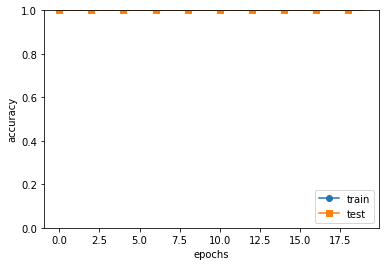

34min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [530]:
%%timeit -r 1 -n 1
max_epochs = 5

network = SimpleConvnet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, X_train, y_train, X_val, y_val,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='AdaGrad', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [526]:
tmp = network.predict(X_test)
pred = np.argmax(tmp,axis=1)
pred

array([7, 2, 1, ..., 4, 5, 6])

In [528]:
accuracy_score(y_test, pred)

0.987

# 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


* 1.畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
* 2.ReLU
* 3.最大プーリング
* 4.畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
* 5.ReLU
* 6.最大プーリング
* 7.平滑化
* 8.全結合層　出力ノード数120
* 9.ReLU
* 10.全結合層　出力ノード数84
* 11.ReLU
* 12.全結合層　出力ノード数10
* 13.ソフトマックス関数

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》


[Applications - Keras Documentation](https://keras.io/ja/applications/)



# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

2.


* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

3.


* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。



In [606]:
def q9_func(X, filter_size, b, S=1, P=0):
    FN, C, FH, FW = filter_size.shape  
    N, C, H, W =X.shape
    out_h = int((H + 2*P - FH) / S +1)
    out_w = int((W + 2*P - FW) / S + 1)  

    col = im2col(X, FH, FW, S, P)
    #print(col.shape)
    col_W = filter_size.reshape(FN, -1).T # フィルターの展開
    #print(col_W.shape)
    weight = col_W.shape[0] * col_W.shape[1]

    out = np.dot(col, col_W) + b
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
    return out, weight

### 問1
入力サイズ : 144×144, 3チャンネル

フィルタサイズ : 3×3, 6チャンネル

ストライド : 1

パディング : なし

In [610]:
b = np.zeros((1,1,6))

X = np.random.randn(1, 3, 144, 144)
filter_size = np.zeros((6, 3, 3, 3))

out, weight = q9_func(X, filter_size, b)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 6, 142, 142)
重み : 162(6, 3, 3, 3)
バイアス : (1, 1, 6)


### 問2

入力サイズ : 60×60, 24チャンネル

フィルタサイズ : 3×3, 48チャンネル

ストライド　: 1

パディング : なし

In [612]:
b = np.zeros((1,1,48))

X = np.random.randn(1, 24, 60, 60)
filter_size = np.zeros((48, 24, 3, 3))

out, weight = q9_func(X, filter_size, b)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 48, 58, 58)
重み : 10368(48, 24, 3, 3)
バイアス : (1, 1, 48)


### 問3

入力サイズ : 20×20, 10チャンネル

フィルタサイズ: 3×3, 20チャンネル

ストライド : 2

パディング : なし

In [628]:
b = np.zeros((1,1,20))

X = np.random.randn(1, 10, 20, 20)
#print(X[0][0][0])
filter_size = np.ones((20, 10, 3, 3))

out, weight = q9_func(X, filter_size, b, 2)

print("解答 : \n出力サイズ：{}\n重み : {}{}".format(out.shape, weight, filter_size.shape))
print("バイアス : {}".format(b.shape))

解答 : 
出力サイズ：(1, 20, 9, 9)
重み : 1800(20, 10, 3, 3)
バイアス : (1, 1, 20)


strideが2なので、(20,20)の列の内18までしか畳み込めておらず、19,20行列目は無視されている。
strideを1にするか、フィルタをsirideとかけたときに20の公約数になるように調節すればちゃんと全部使われるはず。

# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


* 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
* 高さや幅方向を持たない1×1のフィルタの効果